In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from konlpy.tag import Kkma
from konlpy.utils import pprint
from IPython.display import clear_output

from models import *
from utils import DataLoader

In [2]:
EPOCHS = 10
BATCH_SIZE = 256
ETA = 1e-3

In [3]:
# dloader = DataLoader(10)
train_loader = DataLoader(BATCH_SIZE, mode="train")
valid_loader = DataLoader(BATCH_SIZE, mode="valid")
test_loader = DataLoader(BATCH_SIZE, mode="test")

In [4]:
# x, y = next(dloader.next_batch())

In [5]:
# x[0]

In [6]:
sentence_enc = SentenceEncoder().cuda()
context_enc = ContextEncoder().cuda()
# mine_est = MINE().cuda()
sentiment_clf = SentimentPredictor().cuda()

In [7]:
optimizer = optim.Adam([
    *sentence_enc.parameters(),
    *context_enc.parameters(),
    # *mine_est.parameters(),
    *sentiment_clf.parameters()
], lr=ETA)

In [8]:
bce_criterion = nn.BCELoss()

In [9]:
def compute_accuracy(preds, y):
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0
#     print(preds)
#     print(y)
    
    return torch.mean((y == preds).type(torch.FloatTensor))

In [10]:
def train_step(x, y):
    N = len(x)
    
    #zs = []
    #cs = []
    preds = []
    
    for i in range(N):
        z = []
        n = len(x[i])

        for j in range(n):
            sentence = x[i][j]
            # print(len(sentence))
            sentence = np.array(sentence, dtype=np.float32)
            sentence = torch.LongTensor(sentence).cuda().view(1, -1, 1)

            z.append(sentence_enc(sentence))

        z = torch.stack(z, dim=1)
        c = context_enc(z)
        
        #zs.append(z)
        #cs.append(c)
        
        pred = sentiment_clf(c)
        preds.append(pred)
        
    preds = torch.cat(preds, dim=0).view(-1)
    y = torch.FloatTensor(y).cuda()
    
    #mi = mine_est(zs, cs)
    #loss_mi = -mi
    loss_bce_0 = bce_criterion(preds[y == 0], y[y == 0])
    loss_bce_1 = bce_criterion(preds[y == 1], y[y == 1])
    # print(loss_mi, loss_bce)

    loss_bce = (5/6)*loss_bce_0 + (1/6)*loss_bce_1
    
    #loss = loss_mi + loss_bce
    loss = loss_bce
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = compute_accuracy(preds, y)
    
    return loss.item(), acc

In [11]:
def test_step(x, y):
    N = len(x)
    preds = []
    
    for i in range(N):
        z = []
        n = len(x[i])

        for j in range(n):
            sentence = x[i][j]
            # print(len(sentence))
            sentence = np.array(sentence, dtype=np.float32)
            sentence = torch.LongTensor(sentence).cuda().view(1, -1, 1)

            z.append(sentence_enc(sentence))

        z = torch.stack(z, dim=1)
        c = context_enc(z)
        
        pred = sentiment_clf(c)
        preds.append(pred)
        
    preds = torch.cat(preds, dim=0).view(-1)
    y = torch.FloatTensor(y).cuda()
    
    acc = compute_accuracy(preds, y)
    return acc

In [12]:
def train_mode():
    sentence_enc.train()
    context_enc.train()
    #mine_est.train()
    sentiment_clf.train()

def eval_mode():
    sentence_enc.eval()
    context_enc.eval()
    #mine_est.eval()
    sentiment_clf.eval()

In [13]:
def train():
    
    train_losses = []
    train_accs = []
    valid_accs = []
    
    for e in range(EPOCHS):
        
        train_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        train_mode()
        
        for x, y in train_loader.next_batch():
            loss, acc = train_step(x, y)
            train_loss += loss
            train_acc += acc
            
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
            
        eval_mode()
        
        with torch.no_grad():
            for x, y in valid_loader.next_batch():
                acc = test_step(x, y)
                valid_acc += acc
                
        valid_acc /= len(valid_loader)
        
        valid_accs.append(valid_acc)
        
        torch.save(sentence_enc, "ckpts/sentence_enc.pt")
        torch.save(context_enc, "ckpts/context_enc.pt")
        torch.save(sentiment_clf, "ckpts/sentiment_clf.pt")
        
        clear_output(wait=True)

        print(f"Epochs {e+1}/{EPOCHS}")
        print(f"Train loss: {train_loss:.6f}, train acc: {train_acc:.4f}, valid acc: {valid_acc:.4f}")
        
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        axes[0].plot(train_losses)
        axes[0].set_title("train loss")
        axes[0].set_xlabel("epochs")
        axes[0].set_ylabel("loss")
        
        axes[1].plot(train_accs)
        axes[1].set_title("train acc")
        axes[1].set_xlabel("epochs")
        axes[1].set_ylabel("acc")
        
        axes[2].plot(valid_accs)
        axes[2].set_title("valid acc")
        axes[2].set_xlabel("epochs")
        axes[2].set_ylabel("acc")
        
        plt.show()

Epochs 1/10
Train loss: 0.589450, train acc: 0.3308, valid acc: 0.1758


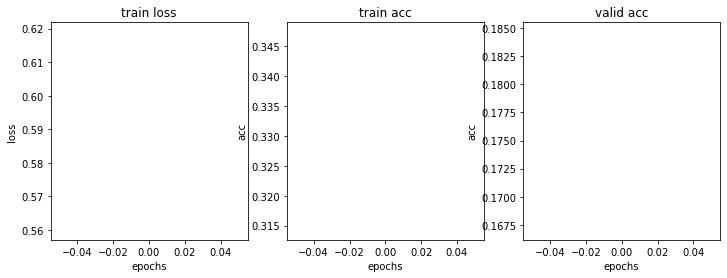

In [ ]:
train()